In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba

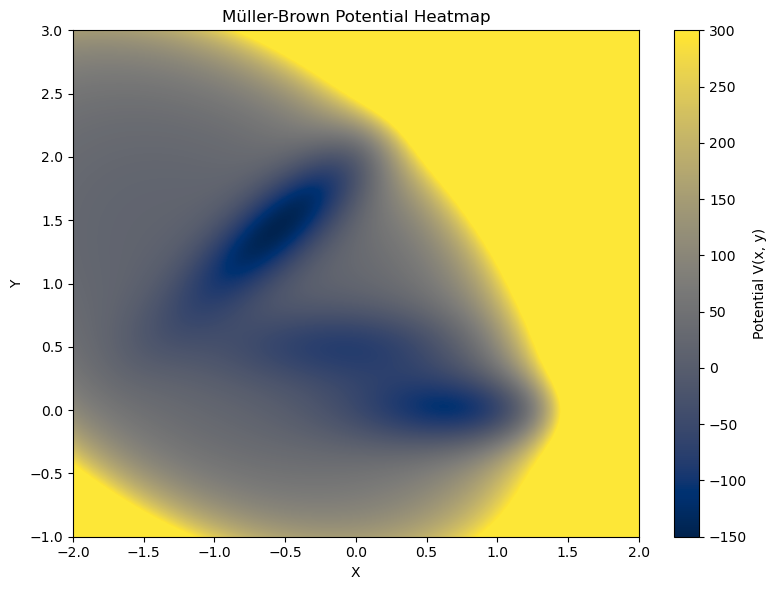

In [2]:
A = np.array([-200, -100, -170, 15])
a = np.array([-1, -1, -6.5, 0.7])
b = np.array([0, 0, 11, 0.6])
c = np.array([-10, -10, -6.5, 0.7])
x0 = np.array([1, 0, -0.5, -1])
y0 = np.array([0, 0.5, 1.5, 1])

def generate_muller_brown_dataset(N, x_range=(-1.5, 1.5), y_range=(-0.7, 2.0)):
    """
    Generates a dataset of grid points with Müller-Brown potential values.

    Parameters:
    - N (int): Number of points along each axis (total points will be N*N).
    - x_range (tuple): The range (min, max) for the x-axis. Default is (-1.5, 1.5).
    - y_range (tuple): The range (min, max) for the y-axis. Default is (-0.7, 0.7).

    Returns:
    - X (numpy.ndarray): 2D array of x-coordinates with shape (N, N).
    - Y (numpy.ndarray):}2D array of y-coordinates with shape (N, N).
    - Z (numpy.ndarray): 2D array of potential values with shape (N, N).
    """
    # Define Müller-Brown potential parameters


    # Create a grid of x and y values
    x = np.linspace(x_range[0], x_range[1], N)
    y = np.linspace(y_range[0], y_range[1], N)
    X, Y = np.meshgrid(x, y)

    # Initialize the potential with zeros
    Z = np.zeros_like(X)

    # Compute the Müller-Brown potential for each component
    for i in range(4):
        exponent = a[i] * (X - x0[i])**2 + b[i] * (X - x0[i])*(Y-y0[i]) + c[i] * (Y - y0[i])**2
        Z += A[i] * np.exp(exponent)

    return X, Y, Z

def plot_muller_brown_heatmap(X, Y, Z, trj, cmap='plasma', vmin=-300, vmax=300):
    """
    Plots a heatmap of the Müller-Brown potential with colorbar limits set between vmin and vmax.

    Parameters:
    - X (numpy.ndarray): 2D array of x-coordinates.
    - Y (numpy.ndarray): 2D array of y-coordinates.
    - Z (numpy.ndarray): 2D array of potential values.
    - cmap (str): Colormap for the heatmap. Default is 'plasma'.
    - vmin (float): Minimum value for color scaling. Default is -300.
    - vmax (float): Maximum value for color scaling. Default is 300.
    """
    plt.figure(figsize=(8, 6))
    
    # Create the heatmap using imshow with specified vmin and vmax
    # To ensure correct aspect ratio and orientation, we set extent and origin
    extent = [X.min(), X.max(), Y.min(), Y.max()]
    im = plt.imshow(Z, extent=extent, origin='lower', cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)

    # Add a colorbar to show the potential scale
    cbar = plt.colorbar(im)
    cbar.set_label('Potential V(x, y)')

    # Label the axes
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Müller-Brown Potential Heatmap')
    
    plt.plot(*trj.T)

    plt.tight_layout()
    plt.show()

N = 500  # Grid size for higher resolution heatmap
X, Y, Z = generate_muller_brown_dataset(N, y_range=(-1.0, 3.0), x_range=(-2.0, 2.0))

# Plot the heatmap with colorbar limits between -300 and 300
plot_muller_brown_heatmap(X, Y, Z, np.zeros(2), cmap='cividis', vmin=-150, vmax=300)


In [3]:
@numba.njit
def mullerBrown(x, y):
    zi = A * np.exp(a * (x - x0)**2 + b * (x - x0) * (y - y0) + c * (y - y0)**2)
    dx = np.sum((2 * a * (x - x0) + b * (y - y0)) * zi)
    dy = np.sum((b * (x - x0) + 2 * c * (y - y0)) * zi)
    return np.sum(zi), dx, dy


In [4]:
@numba.njit
def velocityVerlet(n, eInit=50.0):

    pos = np.zeros((n, 2))
    conserved = np.zeros(n // 1000)
    pos[0] = np.array([-0.8, 0.5])
    u, dudx, dudy = mullerBrown(pos[0, 0], pos[0, 1])
    
    eKin = eInit - u
    if eKin < 1.0:
        eKin = 1.0
    vInit = np.sqrt(eKin)
    vel = np.zeros(2)
    theta = 2 * np.pi * np.random.rand()
    vel[0] = vInit * np.cos(theta)
    vel[1] = vInit * np.sin(theta)
    print(u, np.sum(vel**2))
    
    dt = 5e-4

    for i in range(n-1):
        pos[i+1] = pos[i] + vel * dt + 0.5 * np.array([-dudx, -dudy]) * dt**2
        vel += 0.5 * np.array([-dudx, -dudy]) * dt
        u, dudx, dudy = mullerBrown(pos[i+1, 0], pos[i+1, 1])
        vel += 0.5 * np.array([-dudx, -dudy]) * dt
        
        if i % 1000 == 0:
            conserved[i//1000] = u + 0.5 * np.sum(vel**2)
    return pos, conserved
    
@numba.njit
def langevin(n, T=1.0):
    pos = np.zeros((n, 2))
    conserved = np.zeros(n // 1000)
    vel = np.zeros(2)
    pos[0] = np.array([-0.5, 1.2])
    vel = 10.0 * np.random.rand(2)
    u, dudx, dudy = mullerBrown(pos[0, 0], pos[0, 1])

    dt = 5e-4
    
    gamma = 1.0
    theta = np.exp(-gamma * dt)
    sigma = np.sqrt((1-theta**2) * T)

    for i in range(n-1):
        vel += 0.5 * np.array([-dudx, -dudy]) * dt
        vel = theta * vel + sigma * np.random.randn(2)
        
        pos[i+1] = pos[i] + 0.5 * vel * dt
        
        u, dudx, dudy = mullerBrown(pos[i+1, 0], pos[i+1, 1])
        
        vel += 0.5 * np.array([-dudx, -dudy]) * dt
        
        if i % 1000 == 0:
            conserved[i//1000] = u + 0.5 * np.sum(vel**2)
    return pos, conserved

In [5]:
pos, conserved = velocityVerlet(int(1e6), eInit=0.0)
print((conserved[-1]-conserved[0])/conserved[0])

-39.92675570642041 39.92675570642041
-5.875122564774424e-05


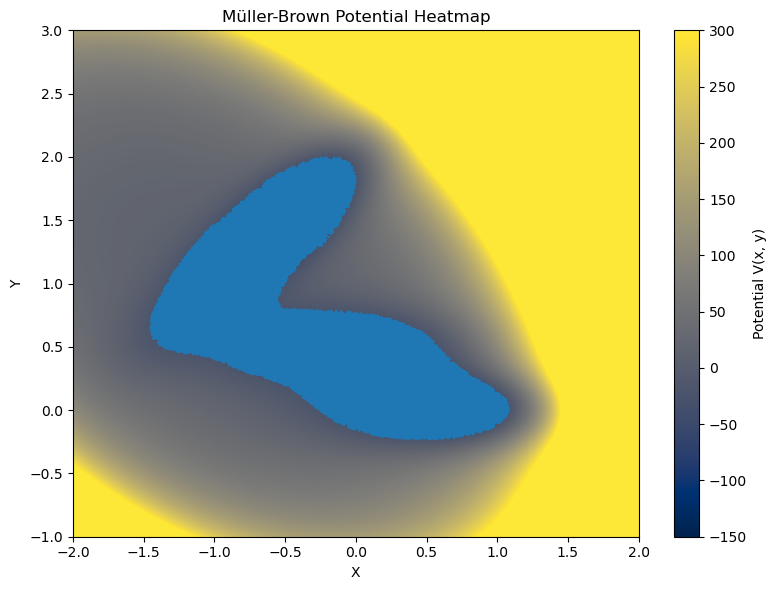

In [6]:
plot_muller_brown_heatmap(X, Y, Z, pos[::50], cmap='cividis', vmin=-150, vmax=300)